# Robustness Analysis for LeNER-Br (Portuguese Legal NER)

This notebook evaluates robustness of the fine-tuned Portuguese BERT NER model on LeNER-Br without retraining. Perturbations simulate noise, masking, and semantic-preserving substitutions to stress test entity extraction in legal text.

## 1. Setup and Model Loading

Load libraries, dataset, label space, tokenizer, and the fine-tuned model saved from the training notebook.

In [1]:
import os
import random
import string
import unicodedata
from collections import Counter, defaultdict

import evaluate
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoModelForTokenClassification, AutoTokenizer

# Reproducibility for perturbations
random.seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


Using device: cuda


## 2. Dataset and Label Space

Load LeNER-Br, rebuild the label mapping used during training, and keep the tag-to-ID mapping explicit.

In [2]:
dataset_id = "peluz/lener_br"
hf_token = os.getenv("HF_TOKEN")

lener = load_dataset(dataset_id, token=hf_token)
print(lener)

ner_feature = lener["train"].features["ner_tags"]
label_list = ner_feature.feature.names
num_labels = len(label_list)
id2label = {i: l for i, l in enumerate(label_list)}
label2id = {l: i for i, l in enumerate(label_list)}

tag2id = {
    "O": 0,
    "B-ORGANIZACAO": 1,
    "I-ORGANIZACAO": 2,
    "B-PESSOA": 3,
    "I-PESSOA": 4,
    "B-TEMPO": 5,
    "I-TEMPO": 6,
    "B-LOCAL": 7,
    "I-LOCAL": 8,
    "B-LEGISLACAO": 9,
    "I-LEGISLACAO": 10,
    "B-JURISPRUDENCIA": 11,
    "I-JURISPRUDENCIA": 12,
}
print("Labels:", label_list)


c:\Users\diogo\Repositorios\ner_smalllm_project\.venv\Lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for peluz/lener_br contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/peluz/lener_br
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 7828
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1177
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 1390
    })
})
Labels: ['O', 'B-ORGANIZACAO', 'I-ORGANIZACAO', 'B-PESSOA', 'I-PESSOA', 'B-TEMPO', 'I-TEMPO', 'B-LOCAL', 'I-LOCAL', 'B-LEGISLACAO', 'I-LEGISLACAO', 'B-JURISPRUDENCIA', 'I-JURISPRUDENCIA']


## 3. Robustness Evaluation Pipeline

Load the fine-tuned Portuguese BERT model, define generic NER inference, and a reusable robustness evaluator that applies perturbations and computes seqeval metrics.

In [4]:
metric = evaluate.load("seqeval")

model_dir = r"C:\Users\diogo\Repositorios\ner_smalllm_project\notebooks\models\lenerbr_bert_base"

model = AutoModelForTokenClassification.from_pretrained(model_dir)
model.config.id2label = id2label
model.config.label2id = label2id
model.to(device)

tokenizer = AutoTokenizer.from_pretrained(model_dir)


def ner_predict(tokens, model, tokenizer, label_list):
    '''Runs NER on pre-tokenized input and returns one label per original token.'''
    encoding = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
    )
    word_ids = encoding.word_ids()
    encoding = {k: v.to(device) for k, v in encoding.items()}
    model.eval()
    with torch.no_grad():
        outputs = model(**encoding)
    pred_ids = outputs.logits.argmax(-1).cpu().numpy()[0]

    preds = []
    seen = set()
    for idx, word_id in enumerate(word_ids):
        if word_id is None or word_id in seen:
            continue
        seen.add(word_id)
        preds.append(label_list[pred_ids[idx]])
    return preds


def evaluate_robustness(dataset, perturb_fn, metric, label_list, max_examples=None):
    '''Applies a perturbation to each example, runs NER, and computes seqeval metrics.'''
    preds, refs = [], []
    for idx, ex in enumerate(dataset):
        if max_examples is not None and idx >= max_examples:
            break
        tokens = ex["tokens"]
        gold_labels = [label_list[t] for t in ex["ner_tags"]]

        perturbed_tokens = perturb_fn(tokens)
        pred_labels = ner_predict(perturbed_tokens, model, tokenizer, label_list)

        max_len = max(len(pred_labels), len(gold_labels))
        pred_aligned = pred_labels + ["O"] * (max_len - len(pred_labels))
        gold_aligned = gold_labels + ["O"] * (max_len - len(gold_labels))

        preds.append(pred_aligned)
        refs.append(gold_aligned)

    return metric.compute(predictions=preds, references=refs)


## 4. Lexical and Orthographic Noise

Character-level and accent perturbations to test sensitivity to surface form changes.

In [5]:
def random_char_noise(token: str, prob: float = 0.1) -> str:
    '''Randomly replaces characters in a token with ASCII letters with given probability.'''
    letters = string.ascii_letters
    noisy = []
    for ch in token:
        if random.random() < prob:
            noisy.append(random.choice(letters))
        else:
            noisy.append(ch)
    return "".join(noisy)


def remove_accents(token: str) -> str:
    '''Removes diacritic marks from a token (Portuguese accent stripping).'''
    nfkd = unicodedata.normalize("NFKD", token)
    return "".join([c for c in nfkd if not unicodedata.combining(c)])


def apply_char_noise(tokens, prob: float = 0.1):
    return [random_char_noise(t, prob=prob) for t in tokens]


def apply_accent_removal(tokens):
    return [remove_accents(t) for t in tokens]


## 5. Context and Masking Perturbations

Inject filler tokens or mask existing ones to simulate context drift and missing evidence.

In [6]:
def insert_noise_words(tokens, prob: float = 0.1):
    '''Inserts random filler tokens between words with a given probability.'''
    noise_words = ["xxx", "lorem", "teste", "ruido"]
    output = []
    for tok in tokens:
        output.append(tok)
        if random.random() < prob:
            output.append(random.choice(noise_words))
    return output


def mask_tokens(tokens, prob: float = 0.15):
    '''Randomly replaces tokens with [MASK] with a given probability.'''
    mask_tok = tokenizer.mask_token if tokenizer.mask_token else "[MASK]"
    return [mask_tok if random.random() < prob else t for t in tokens]


## 6. Synonym-based Perturbations (Careful Design)

Inspect frequent tokens per entity to craft conservative synonym substitutions that preserve meaning.

In [7]:
label_token_freq = defaultdict(Counter)

for ex in lener["train"]:
    tokens = ex["tokens"]
    tags = ex["ner_tags"]
    for tok, tag_id in zip(tokens, tags):
        label_token_freq[tag_id][tok] += 1

for tag_id in range(1, 13):  # skip 'O'
    label_name = label_list[tag_id]
    print(f"=== Top tokens for {label_name} (id={tag_id}) ===")
    for tok, count in label_token_freq[tag_id].most_common(20):
        print(f"{tok}	{count}")


=== Top tokens for B-ORGANIZACAO (id=1) ===
Supremo	190
Ministério	125
Superior	89
Segunda	77
Tribunal	72
ICP-Brasil	71
TCU	65
Infraestrutura	65
STF	51
Plenário	47
MINISTÉRIO	41
Distrito	37
STJ	36
MPM	36
Conselho	35
União	34
2ª	33
Exército	33
Câmara	28
Secretaria	26
=== Top tokens for I-ORGANIZACAO (id=2) ===
de	384
Tribunal	310
Federal	285
do	192
da	161
Turma	134
Justiça	118
Público	114
Brasileira	86
Militar	80
Chaves	72
Públicas	72
e	60
Câmara	59
TURMA	48
Cível	48
FEDERAL	48
DE	45
TRIBUNAL	43
PÚBLICO	41
=== Top tokens for B-PESSOA (id=3) ===
LUIZ	33
José	31
Carlos	28
Luiz	28
Luis	28
Robsmar	24
RAFAEL	23
JOSÉ	22
ALEXANDRE	22
MARCO	21
Cármen	20
André	18
Jorge	18
Ricardo	18
Marco	18
Dias	18
Rosa	18
Celso	17
Napoleão	16
Anderson	16
=== Top tokens for I-PESSOA (id=4) ===
de	161
DE	137
da	62
Silva	60
DA	41
Oliveira	34
Carlos	32
LIMA	32
PEREIRA	29
Gomes	29
Aurélio	28
AURÉLIO	27
Mattos	26
FUX	26
SILVA	25
Lima	25
Filho	25
Fux	24
Ferreira	21
Souza	21
=== Top tokens for B-TEMPO (id=5) ===
24/08

In [8]:
SYNONYM_MAP = {
    # =======================
    # Titles / persons
    # =======================
    "MINISTRO": "AUTORIDADE",
    "MINISTRA": "AUTORIDADE",
    "JUIZ": "MAGISTRADO",
    "JUÍZA": "MAGISTRADA",
    "RELATOR": "MAGISTRADO",
    "RELATORA": "MAGISTRADA",
    # =======================
    # Organizations / courts
    # =======================
    "TRIBUNAL": "CORTE",
    "PLENÁRIO": "SESSAO",
    "CÂMARA": "COLEGIO",
    "CAMARA": "COLEGIO",  # versão sem acento
    "TURMA": "PAINEL",
    # =======================
    # Legislation
    # =======================
    "LEI": "NORMA",
    "ARTIGO": "DISPOSITIVO",
    "ART": "DISP",  # versão abreviada, mas ainda coerente
    "ACÓRDÃO": "DECISAO",
    "ACORDAO": "DECISAO",
    # =======================
    # Common uppercase variants
    # =======================
    "LEI": "NORMA",
    "LEIS": "NORMAS",
    "ARTIGO": "DISPOSITIVO",
    "ARTIGOS": "DISPOSITIVOS",
    "SÚMULA": "ENUNCIADO",
}


def synonym_noise(tokens):
    '''Replaces tokens with predefined synonyms when available.'''
    return [SYNONYM_MAP.get(t, t) for t in tokens]

## 7. Quantitative Robustness Results

Evaluate baseline vs. multiple perturbations on a validation subset (first 200 examples).

In [ ]:
val_subset = lener["validation"].select(range(200))

results_baseline = evaluate_robustness(val_subset, lambda x: x, metric, label_list, max_examples=200)
results_accents = evaluate_robustness(val_subset, apply_accent_removal, metric, label_list, max_examples=200)
results_char = evaluate_robustness(val_subset, lambda toks: apply_char_noise(toks, prob=0.1), metric, label_list, max_examples=200)
results_insert = evaluate_robustness(val_subset, insert_noise_words, metric, label_list, max_examples=200)
results_mask = evaluate_robustness(val_subset, mask_tokens, metric, label_list, max_examples=200)
results_syn = evaluate_robustness(val_subset, synonym_noise, metric, label_list, max_examples=200)

rows = [
    ["Baseline", results_baseline["overall_f1"]],
    ["Accent removal", results_accents["overall_f1"]],
    ["Char noise (p=0.1)", results_char["overall_f1"]],
    ["Word insertion", results_insert["overall_f1"]],
    ["Masking (p=0.15)", results_mask["overall_f1"]],
    ["Synonym noise", results_syn["overall_f1"]],
]

df_robust = pd.DataFrame(rows, columns=["Scenario", "F1"])
print(df_robust)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


             Scenario        F1
0            Baseline  0.866373
1      Accent removal  0.823529
2  Char noise (p=0.1)  0.652632
3      Word insertion  0.102339
4    Masking (p=0.15)  0.730539
5       Synonym noise  0.845697


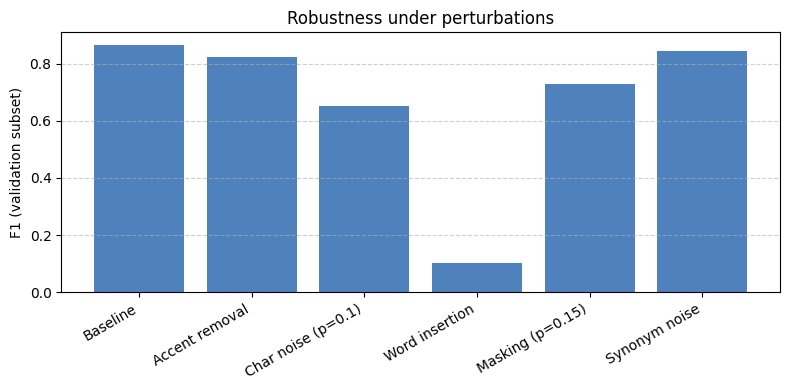

In [10]:
plt.figure(figsize=(8, 4))
plt.bar(df_robust["Scenario"], df_robust["F1"], color="#4f81bd")
plt.xticks(rotation=30, ha="right")
plt.ylabel("F1 (validation subset)")
plt.title("Robustness under perturbations")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()


## 8. Qualitative Examples

Inspect a few validation sentences before and after perturbations to see how entity predictions change.

In [11]:
def format_predictions(tokens, labels):
    return "".join([f"{t:<20} {l}" for t, l in zip(tokens, labels)])

sample_indices = [0, 1, 2]
perturbations = {
    "Accent removal": apply_accent_removal,
    "Char noise": lambda toks: apply_char_noise(toks, prob=0.1),
    "Synonym noise": synonym_noise,
}

for idx in sample_indices:
    ex = val_subset[idx]
    tokens = ex["tokens"]
    pred_base = ner_predict(tokens, model, tokenizer, label_list)
    print(f"=== Example {idx} ===")
    print("Tokens and baseline predictions:")
    print(format_predictions(tokens, pred_base))

    for name, fn in perturbations.items():
        pert_tokens = fn(tokens)
        pred_pert = ner_predict(pert_tokens, model, tokenizer, label_list)
        max_len = max(len(pred_pert), len(pert_tokens))
        padded_tokens = pert_tokens + ["<PAD>"] * (max_len - len(pert_tokens))
        padded_preds = pred_pert + ["O"] * (max_len - len(pred_pert))
        print(f"{name}:")
        print(format_predictions(padded_tokens, padded_preds))


=== Example 0 ===
Tokens and baseline predictions:
E                    OM                    OE                    ON                    OT                    OA                    OÓrgão                O:                    O8ª                   B-ORGANIZACAOTURMA                I-ORGANIZACAOCÍVEL                I-ORGANIZACAOClasse               O:                    OAPELAÇÃO             OCÍVEL                ON                    O.                    OProcesso             O:                    O20150110436469APC    B-JURISPRUDENCIA(                    O0012843-03.2015.8.07.0001 B-JURISPRUDENCIA)                    OApelante             O(                    Os                    O)                    O:                    OBRASILIA             B-ORGANIZACAOCURSOS               I-ORGANIZACAOE                    I-ORGANIZACAOCONCURSOS            I-ORGANIZACAOLTDA                 I-ORGANIZACAOGRANCURSOS           B-ORGANIZACAOESCOLA               I-ORGANIZACAOPARA                 I-O

## 9. Discussion and Conclusions

The robustness evaluation provides a detailed profile of how the legal-domain NER model reacts to different perturbations applied to the validation dataset. Using the clean data as a baseline (F1 ≈ **0.866**), we systematically analyzed how orthographic, semantic, and structural modifications affect the model's performance. The results not only highlight the model’s strengths and weaknesses, but also motivate concrete hypotheses for improving robustness in future iterations.

---

### **Accent Removal (F1 ≈ 0.823)**  
Removing diacritics causes a modest performance degradation (~4 p.p.), indicating that the model is largely invariant to accent loss. This is expected given Portuguese WordPiece tokenization: many accented forms have stable subword decompositions even when accents are missing (“AÇÃO” → “ACAO”). Errors arise primarily when accent removal merges subwords or changes morphological boundaries.

**Hypothesis for improving robustness:**
- **Augment training data with accent-stripped variants.** This would help the model internalize orthographic equivalences and reduce reliance on specific surface forms.

---

### **Character Noise (p=0.1, F1 ≈ 0.652)**  
Random character corruption reduces F1 by ~21 p.p., showing that the model is sensitive to morphological disturbances. Legal NER heavily depends on exact lexical forms (“Lei”, “Súmula”, “HC”, “Ministério”), and corruption disrupts subword segmentation. Even mild corruption can cause the tokenizer to output subwords that never appeared in training.

**Hypotheses for improvement:**
1. **Character-level noise augmentation** during training to encourage invariance to small orthographic errors.  
2. **Switching to a tokenizer with finer subword granularity** (e.g., byte-level BPE) to reduce dependence on precise spelling.  
3. **Contrastive training** between clean and corrupted sequences to stabilize representations.

---

### **Masking (p=0.15, F1 ≈ 0.731)**  
Masking removes entire lexical units, forcing the model to rely solely on context. The moderately high F1 suggests that contextual embeddings often compensate for missing words, but performance drops substantially when masked tokens include entity anchors.

**Hypotheses for improvement:**
1. **Entity-aware masking strategies** during fine-tuning, masking preferentially outside entities to improve contextual reasoning.  
2. **Pretraining with higher masking rates** (20–30%) to promote reliance on deeper contextual information.  
3. **Multi-task learning (MLM + NER)** to reinforce stable internal representations.

---

### **Synonym Substitution (F1 ≈ 0.845)**  
The small decrease from baseline demonstrates high semantic robustness. Replacing “TRIBUNAL” by “CORTE”, “MINISTRO” by “AUTORIDADE”, or “LEI” by “NORMA” intentionally alters surface forms while preserving legal semantics. The model successfully leverages context to recover entity types.

**Hypothesis for improvement:**
- **Domain synonym augmentation** to further strengthen semantic invariance and reduce reliance on memorized lexical triggers.

---

### **Word Insertion (F1 ≈ 0.102)**  
This is the most destructive perturbation. Random filler words disrupt sequential and contextual structure, causing the attention mechanism to integrate irrelevant noise and dilute essential cues. Transformers do not inherently distinguish important from unimportant tokens without training-time guidance.

**Hypotheses for improvement:**
1. **Training with synthetic word-insertion noise** to teach the model to ignore irrelevant tokens.  
2. **Attention-masking or hierarchical architectures** (e.g., Longformer, BigBird) that are less sensitive to local clutter.  
3. **Noise-filtering preprocessing modules** for real-world OCR or concatenated text pipelines.  
4. **Adversarial training with structural perturbations** to inoculate the model against sequence clutter.

---

## **Overall Interpretation**

These results reveal the following robustness profile:

- **Strong robustness** to meaning-preserving transformations (synonyms)  
- **Moderate robustness** to orthographic variation (accents)  
- **Significant fragility** to character-level distortions and token masking  
- **Extreme vulnerability** to structural noise (word insertion)

This vulnerability pattern aligns with known behavior of Transformer-based NER models, which rely on lexical anchors, stable subword boundaries, and consistent sequential structure.

---

## **Concluding Remarks and Future Work**

This robustness analysis provides actionable insights into how the legal-domain BERT model behaves under controlled disturbances. The observed weaknesses suggest several promising paths for improvement:

- **custom data augmentation focused on orthographic and structural noise**
- **entity-aware masking techniques**
- **hybrid character–token architectures**
- **adversarial training strategies**